In [1]:
library(igraph, warn.conflicts = F, verbose = F)
library(foreach, warn.conflicts = F, verbose = F)
library(doParallel, warn.conflicts = F, verbose = F)
library(ggplot2)

Loading required package: iterators

Loading required package: parallel



In [2]:
totalCores = detectCores()

In [3]:
cluster <- makeCluster(totalCores[1]-1) 
registerDoParallel(cluster)

In [4]:
alpha <- 0.01
n <- 1000
p <- 1.1*log(n)/n
n_retry <- 10
gamma<-3

In [5]:
# k_min <- 2
# k_max <- k_min * floor(n^(1/(gamma - 1)))+50

In [6]:
metric <- function(g, method = "be") {
    if (method == "be") {
        return(betweenness(g, normalized = F))
    } else if (method == "de") {
        return(degree(g))
    }
}

In [7]:
alphas<-c(0.001,seq(from=0.1, to=0.9, by=0.1))

In [8]:
degs <- sample(x = 2:500, size = 5000, prob = (2:500)^(-3), replace = T)

In [9]:
generate <- function(..., method = "er") {
    if (method == "er") {
        g <- sample_gnp(n, p)
        while (clusters(g)$no > 1) {
            g <- sample_gnp(n, p)
        }
        return(g)
    } else if (method == "pa") {
        g <- sample_pa(..., directed = F, power = 1.5)
        return(g)
    } else if (method == "conf") {
        g <- sample_degseq(out.deg = ..., method = "simple.no.multiple")
        while (clusters(g)$no > 1) {
            g <- sample_degseq(out.deg = ..., method = "simple.no.multiple")
        }
        print(components(g)$no)
        return(g)
    }

}

In [10]:
destroy <- function(g, ...) {
    n <- length(g)
    V(g)$cst_ids <- c(1:n)
    V(g)$load <- metric(g, ...)
    V(g)$capacity <- (1 + alphas[index_alpha]) * V(g)$load

    nodes_to_fail <- order(V(g)$load, decreasing = T)[1]
    cst_ids_failed <- V(g)$cst_ids[nodes_to_fail]

    g_failed <- g

    counter <- 0

    while (length(nodes_to_fail > 0)) {
        g_failed <- delete_vertices(g_failed, nodes_to_fail)

        V(g_failed)$new_load <- metric(g_failed)

        failing_nodes <- V(g_failed)$new_load > V(g_failed)$capacity

        nodes_to_fail <- V(g_failed)[failing_nodes]

        cst_ids_failed <- c(cst_ids_failed, V(g_failed)$cst_ids[nodes_to_fail])

        counter <- counter + 1
    }
    return(list(fraction_survived = length(g_failed)/length(g), counter = counter))
}

In [11]:
results <- foreach(index_alpha = 1:length(alphas), .combine = cbind) %dopar% {
    library(igraph, warn.conflicts = F, verbose = F)

    percent <- vector()
    counts <- vector()
    for (i in 1:n_retry) {
        g <- generate(degs, method = "pa")
        output_sim <- destroy(g, method = "be")
        percent[i] <- output_sim$fraction_survived
        counts[i] <- output_sim$counter
    }

    return(c(mean(percent), sqrt(var(percent)), mean(counts), components(g)$no))
}

In [12]:
rownames(results)<- c('mean', 'std', 'counts', 'components')
results<-t(results)
res<-cbind(results, alphas)

colnames(res)<- c('mean', 'std', 'counts','components', 'alphas')

rownames(res)<-NULL

res<-as.data.frame(res)

In [13]:
res

mean,std,counts,components,alphas
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5,0,1,1,0.001
0.5,0,1,1,0.100
0.5,0,1,1,0.200
0.5,0,1,1,0.300
0.5,0,1,1,0.400
0.5,0,1,1,0.500
0.5,0,1,1,0.600
0.5,0,1,1,0.700
0.5,0,1,1,0.800


In [14]:
# write.csv(res, 'er_p5_n_10attempts.csv')

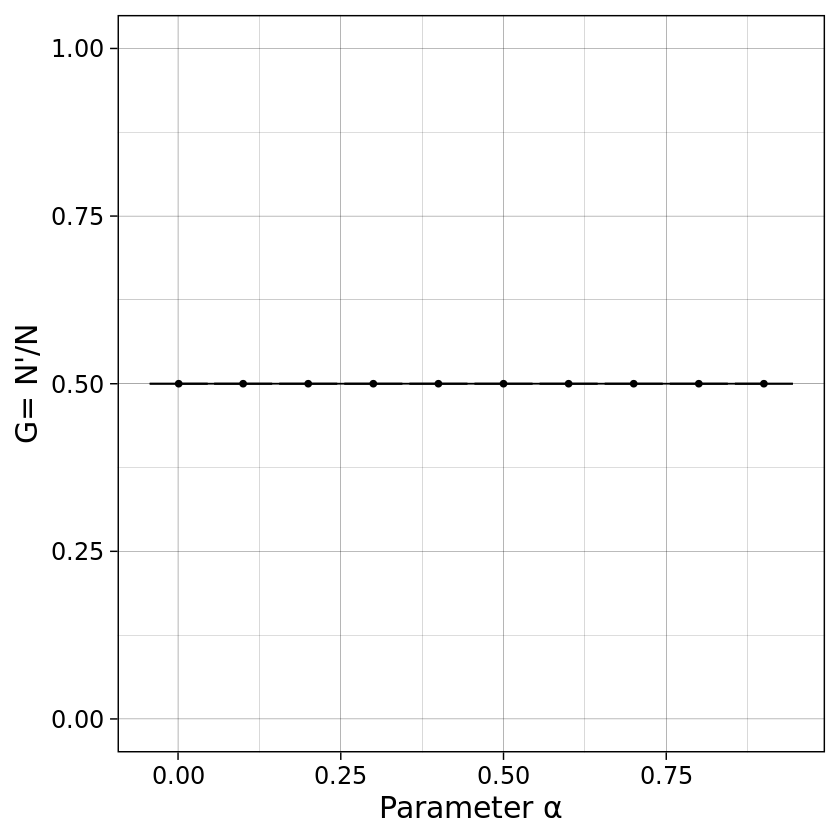

In [15]:
ggplot(res, aes(x = alphas, y = mean)) + geom_line() + geom_point() + geom_errorbar(aes(ymin = mean -
    std, ymax = mean + std)) + labs(x = expression(paste("Parameter ", alpha)), y = "G= N'/N") +
    theme_linedraw(base_size = 18, ) + scale_color_manual(values = c("#999999", "#E69F00"),
    )+ylim(0,1)

In [16]:
#Stop cluster
stopCluster(cluster)
